In [1]:
# --- Manipulación de datos ---
import pandas as pd
import numpy as np
import itertools
from IPython.display import display

# --- Estadística y modelos ---
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.tools import add_constant
from linearmodels.panel import PanelOLS

# --- Visualización ---
import matplotlib.pyplot as plt

# --- Mapas ---
import folium
from folium.plugins import HeatMap
import branca.colormap as cm
import webbrowser

# --- Optimización y funciones especiales ---
from scipy.optimize import minimize
from scipy.special import factorial
from scipy.stats import norm


In [2]:
data = "Afluencia mensual metro.xlsx"
hojas = pd.read_excel(data, sheet_name=None)
print(hojas[list(hojas.keys())[0]].columns.tolist())
print(hojas[list(hojas.keys())[0]].columns.tolist())

mapa_estaciones = {
    "ACE": "ACEVEDO",
    "BEO": "BELLO",
    "NIQ": "NIQUIA",
    "XPO": "EXPOSICIONES",
    "JAV": "SAN JAVIER",
    "SAM": "SURAMERICANA",
    "HOS": "HOSPITAL",
    "UNI": "UNIVERSIDAD",
    "LUC": "SANTA LUCIA",
    "FLO": "FLORESTA",
    "EST": "ESTADIO",
    "STA": "LA ESTRELLA",
    "BAN": "SABANETA",
    "ITA": "ITAGUI",
    "CIS": "CISNEROS",
    "AYU": "AYURA",
    "SAA": "SAN ANTONIO",
    "ALP": "ALPUJARRA",
    "TRI": "TRICENTENARIO",
    "CAR": "CARIBE",
    "MAD": "MADERA",
    "BER": "PARQUE BERRIO",
    "PRA": "PRADO",
    "POB": "POBLADO",
    "IND": "INDUSTRIALES",
    "CAT": "AGUACATALA",
    "ENV": "ENVIGADO",
}

# Seleccionar la primera hoja como df
df = hojas[list(hojas.keys())[0]]

df = df.rename(columns=mapa_estaciones)

print(df.columns.tolist())
dfs = []

for nombre_hoja, df in hojas.items():
    try:
        # Suponemos que el nombre de la hoja es el año
        año = int(nombre_hoja)
    except ValueError:
        print(f"⚠️ Hoja {nombre_hoja} ignorada (no es un año)")
        continue

    # --- LIMPIAMOS LOS NOMBRES DE COLUMNAS ---
    df.columns = df.columns.astype(str).str.strip()  # quita espacios

    # Renombrar variantes de Estación a "ESTACION"
    posibles_nombres = ["Estación", "ESTACION", "Estacion", "estacion"]
    for col in posibles_nombres:
        if col in df.columns:
            df = df.rename(columns={col: "ESTACION"})
            break

    if "ESTACION" not in df.columns:
        print(f"⚠️ Hoja {nombre_hoja} ignorada (no tiene columna ESTACION)")
        continue

    # Detectamos columnas de meses
    meses_presentes = [c for c in df.columns if c not in ["ESTACION", "Total"]]

    # Pasamos a formato largo
    df_long = df.melt(
        id_vars=["ESTACION"],
        value_vars=meses_presentes,
        var_name="Mes",
        value_name="Afluencia"
    )
    df_long["Año"] = año

    # --- LIMPIEZA + CAMBIO DE NOMBRES DE ESTACIONES ---
    df_long["ESTACION"] = df_long["ESTACION"].astype(str).str.strip()
    df_long["ESTACION"] = df_long["ESTACION"].replace(mapa_estaciones)

    dfs.append(df_long)

# --- 2. Unimos todo ---
data = pd.concat(dfs, ignore_index=True)
# --- 3. Mapear meses ---
mapa_meses = {
    "Enero": 1, "Febrero": 2, "Marzo": 3, "Abril": 4, "Mayo": 5, "Junio": 6,
    "Julio": 7, "Agosto": 8, "Septiembre": 9, "Octubre": 10, "Noviembre": 11, "Diciembre": 12
}
data["Mes"] = data["Mes"].astype(str).str.strip()  # limpiar espacios
data["Mes_num"] = data["Mes"].map(mapa_meses)

# Si algún mes no se mapea, avisa
if data["Mes_num"].isna().any():
    print("⚠️ Hay meses no reconocidos en la columna 'Mes':")
    print(data.loc[data["Mes_num"].isna(), "Mes"].unique())

# --- 4. Fecha ---
data["Fecha"] = pd.to_datetime(dict(year=data["Año"], month=data["Mes_num"], day=1))

# --- 5. Agrupar por trimestre (con nombres completos de estación) ---
res = (
    data.groupby(["ESTACION", pd.Grouper(key="Fecha", freq="Q")], as_index=False)["Afluencia"]
    .agg(
        aprom="mean",
        asum="sum"
    )
)

# Crear columna AñoT en formato "YYYY-T"
res["AñoT"] = res["Fecha"].dt.year.astype(str) + "-" + res["Fecha"].dt.quarter.astype(str)

# Eliminar la columna Fecha y reordenar
res = res.drop(columns=["Fecha"])[
    ["ESTACION", "AñoT", "aprom", "asum"]
]

print(res.head(20))
res



['Estación', 'Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre', 'Total']
['Estación', 'Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre', 'Total']
['Estación', 'Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre', 'Total']
⚠️ Hay meses no reconocidos en la columna 'Mes':
['Nombre' 'ENERO' 'FEBRERO' 'MARZO' 'ABRIL' 'MAYO' 'JUNIO' 'JULIO'
 'AGOSTO' 'SEPTIEMBRE' 'OCTUBRE' 'NOVIEMBRE' 'DICIEMBRE' 'TOTAL'
 'Unnamed: 14' 'Unnamed: 15' 'Unnamed: 16' 'Unnamed: 17' 'Unnamed: 18'
 'Unnamed: 19' 'Unnamed: 20' 'Unnamed: 21' 'Unnamed: 22' 'Unnamed: 23'
 'Unnamed: 24' 'Unnamed: 25' 'Unnamed: 26' 'Unnamed: 27' 'Unnamed: 28'
 'Unnamed: 29' 'Unnamed: 30' 'Unnamed: 31']
   ESTACION    AñoT          aprom     asum
0   ACEVEDO  2012-1  586976.666667  1760930
1   ACEVEDO  2012-2       591850.

C:\Users\Felipe Bañol\AppData\Local\Temp\ipykernel_3660\2811105964.py:104: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  data.groupby(["ESTACION", pd.Grouper(key="Fecha", freq="Q")], as_index=False)["Afluencia"]


,ESTACION,AñoT,aprom,asum
0,ACEVEDO,2012-1,586976.666667,1760930
1,ACEVEDO,2012-2,591850.0,1775550
2,ACEVEDO,2012-3,617626.666667,1852880
3,ACEVEDO,2012-4,638917.666667,1916753
4,ACEVEDO,2013-1,586402.333333,1759207
...,...,...,...,...
1155,UNIVERSIDAD,2020-4,202522.666667,607568
1156,UNIVERSIDAD,2021-1,202577.333333,607732
1157,UNIVERSIDAD,2021-2,143254.0,429762.0
1158,UNIVERSIDAD,2021-3,222807.566667,668422.7


In [3]:

DatosV = pd.read_excel("C:/Users/Felipe Bañol/Documents/GitHub/Metro2.0/DatosV.xlsx")
DatosV["EDAD"] = pd.to_numeric(DatosV["EDAD"], errors="coerce")
DatosV = DatosV[DatosV["AñoT"] >= "2012-1"]




DatosV["ESTACION"] = DatosV["ESTACION"].replace({"SAN ANTONIO B": "SAN ANTONIO", "SAN JAVIER J": "SAN JAVIER"})
estaciones_validas = [
    "NIQUIA", "BELLO", "MADERA", "ACEVEDO", "TRICENTENARIO", "CARIBE", "UNIVERSIDAD",
    "HOSPITAL", "PRADO", "PARQUE BERRIO", "SAN ANTONIO", "ALPUJARRA", "EXPOSICIONES",
    "INDUSTRIALES", "POBLADO", "AGUACATALA", "AYURA", "ENVIGADO", "ITAGUI", "SABANETA", "LA ESTRELLA", "SAN JAVIER", "SANTA LUCIA", "FLORESTA","ESTADIO", "SURAMERICANA","CISNEROS"
]
DatosV = DatosV[DatosV["ESTACION"].isin(estaciones_validas)]

# --- Crear subconjuntos ---
DatosM = DatosV[DatosV["GENERO"] == "M"]
DatosF = DatosV[DatosV["GENERO"] == "F"]
Datos_joven = DatosV[DatosV["EDAD"] <= 28]
Datos_no_joven = DatosV[DatosV["EDAD"] > 28]
DatosM_joven = DatosV[(DatosV["GENERO"] == "M") & (DatosV["EDAD"] <= 28)]
DatosF_joven = DatosV[(DatosV["GENERO"] == "F") & (DatosV["EDAD"] <= 28)]
DatosM_no_joven = DatosV[(DatosV["GENERO"] == "M") & (DatosV["EDAD"] > 28)]
DatosF_no_joven = DatosV[(DatosV["GENERO"] == "F") & (DatosV["EDAD"] > 28)]
# --- Función para crear conteo ---
años = range(2012, 2023)
trimestres = [1, 2, 3, 4]
todos_trimestres = [f"{año}-{t}" for año, t in itertools.product(años, trimestres)]
estaciones = DatosV["ESTACION"].unique()
DatosV



,AñoT,ESTACION,EDAD,GENERO,Sobrevivencia
24,2012-2,ACEVEDO,27.0,M,1
25,2012-2,ACEVEDO,27.0,F,1
26,2012-3,ACEVEDO,15.0,M,1
27,2013-2,ACEVEDO,25.0,M,1
28,2013-3,ACEVEDO,24.0,M,1
...,...,...,...,...,...
1026,2012-3,UNIVERSIDAD,39.0,M,0
1027,2015-1,UNIVERSIDAD,15.0,F,0
1028,2020-1,UNIVERSIDAD,24.0,M,0
1029,2022-2,UNIVERSIDAD,24.0,M,0


In [4]:



# Diccionario de estaciones y coordenadas
coords = {
    "PARQUE BERRIO": "6.250462303868426,-75.56834000837911",
    "UNIVERSIDAD": "6.26915598179275,-75.5662274347604",
    "SAN ANTONIO": "6.247330146607752,-75.5698201061719",
    "ENVIGADO": "6.174812726117751,-75.59709553476108",
    "POBLADO": "6.213232150899053,-75.57825884840798",
    "EXPOSICIONES": "6.238530638603876,-75.57315109058204",
    "FLORESTA": "6.259010554943915,-75.59786716758109",
    "SANTA LUCIA": "6.258223202357437,-75.60379266359627",
    "CARIBE": "6.277550151742888,-75.56958369058172",
    "HOSPITAL": "6.263899800728917,-75.56357215935357",
    "PRADO": "6.257064210414861,-75.56626869254376",
    "ESTADIO": "6.2535260786987585,-75.58822609455328",
    "INDUSTRIALES": "6.23029508083824,-75.57564105085336",
    "NIQUIA": "6.338005305862645,-75.54419969058134",
    "ACEVEDO": "6.300269893042005,-75.55736196228843",
    "ALPUJARRA": "6.243329387661553,-75.57164971362404",
    "ANDALUCIA": "6.296434019608016,-75.55194856359589",
    "CISNEROS": "6.24908909785412,-75.57484417126771",
    "AYURA": "6.186664356406138,-75.58529863106094",
    "SAN JAVIER": "6.257070663629232,-75.61395739536867",
    "MADERA": "6.316095631702425,-75.5553866635958",
    "TRICENTENARIO": "6.290681332598884,-75.56480136755223",
    "BELLO": "6.33200105209788,-75.55382519499489",
    "SURAMERICANA": "6.253223323834436,-75.58307115195348",
    "ITAGUI": "6.164471586641053,-75.60668072502183",
    "AGUACATALA": "6.1940934008013615,-75.58185203078955",
    "SANTO DOMINGO": "6.29289386348335,-75.54182252280995",
    "SABANETA": "6.157505762419725,-75.6167022617469",
    "LA ESTRELLA": "6.152864366388068,-75.62647850592543",
    "PALMA": "6.231296651941057,-75.60103162165781",
    "AURORA": "6.281180272067294,-75.57300898767743",
    "BICENTENARIO": "6.244295592935814,-75.55876227264393",
    "MIRAFLORES": "6.241609163809552,-75.54900663476063",
    "ACEVEDO K": "6.300269893042005,-75.55736196228843",
    "SAN ANTONIO B": "6.247330146607752,-75.5698201061719"
}

# Crear nueva columna en la base de datos
DatosV["Coordenadas"] = DatosV["ESTACION"].map(coords).fillna(0)
# Primero agregamos la columna de coordenadas como antes
DatosV["Coordenadas"] = DatosV["ESTACION"].map(coords).fillna("0,0")

# Luego separamos en Latitud y Longitud
DatosV[["Latitud", "Longitud"]] = DatosV["Coordenadas"].str.split(",", expand=True)

# Convertir a tipo numérico (float)
DatosV["Latitud"] = DatosV["Latitud"].astype(float)
DatosV["Longitud"] = DatosV["Longitud"].astype(float)

# (Opcional) eliminar la columna original de texto
DatosV = DatosV.drop(columns=["Coordenadas"])
DatosV


,AñoT,ESTACION,EDAD,GENERO,Sobrevivencia,Latitud,Longitud
24,2012-2,ACEVEDO,27.0,M,1,6.300270,-75.557362
25,2012-2,ACEVEDO,27.0,F,1,6.300270,-75.557362
26,2012-3,ACEVEDO,15.0,M,1,6.300270,-75.557362
27,2013-2,ACEVEDO,25.0,M,1,6.300270,-75.557362
28,2013-3,ACEVEDO,24.0,M,1,6.300270,-75.557362
...,...,...,...,...,...,...,...
1026,2012-3,UNIVERSIDAD,39.0,M,0,6.269156,-75.566227
1027,2015-1,UNIVERSIDAD,15.0,F,0,6.269156,-75.566227
1028,2020-1,UNIVERSIDAD,24.0,M,0,6.269156,-75.566227
1029,2022-2,UNIVERSIDAD,24.0,M,0,6.269156,-75.566227


C:\Users\Felipe Bañol\AppData\Local\Temp\ipykernel_3660\1267174694.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conteo = DatosV.groupby(["EdadGrupo", "GENERO"]).size().reset_index(name="Total")
C:\Users\Felipe Bañol\AppData\Local\Temp\ipykernel_3660\1267174694.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([str(abs(int(x))) for x in xticks])


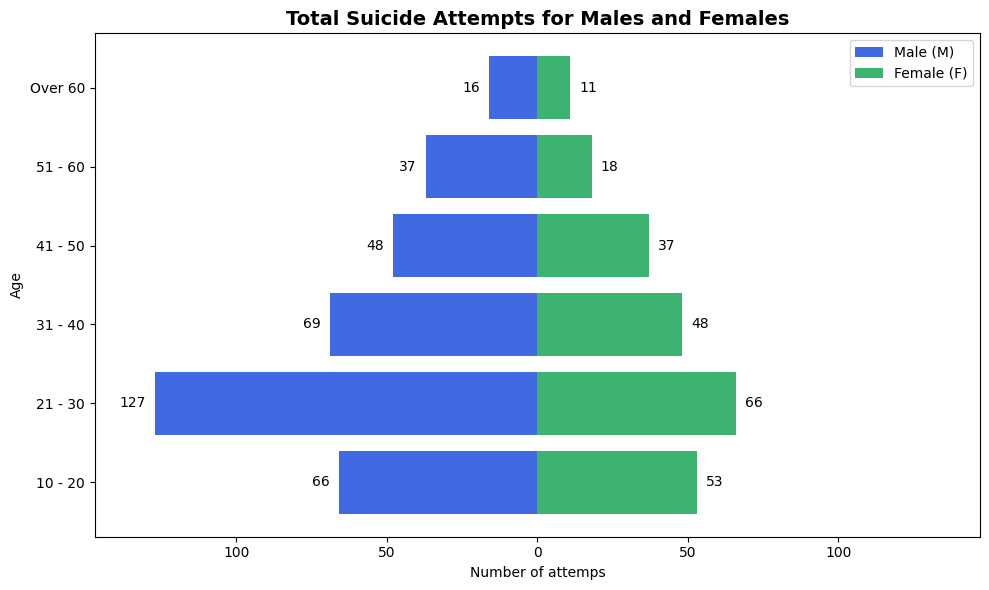

In [5]:
# --- 1. Crear rangos de edad ---
bins = [10, 20, 30, 40, 50, 60, 200]
labels = ["10 - 20", "21 - 30", "31 - 40", "41 - 50", "51 - 60", "Over 60"]

DatosV["EdadGrupo"] = pd.cut(DatosV["EDAD"], bins=bins, labels=labels, right=True)

# --- 2. Contar intentos por género y grupo etario ---
conteo = DatosV.groupby(["EdadGrupo", "GENERO"]).size().reset_index(name="Total")

# --- 3. Pivotear ---
tabla_edad = conteo.pivot(index="EdadGrupo", columns="GENERO", values="Total").fillna(0)
tabla_edad = tabla_edad.reindex(columns=["M", "F"], fill_value=0)
tabla_edad = tabla_edad.reindex(labels)

# --- 4. Graficar pirámide ---
fig, ax = plt.subplots(figsize=(10,6))

# Hombres (M) a la izquierda → valores negativos
ax.barh(tabla_edad.index, -tabla_edad["M"], color="royalblue", label="Male (M)")

# Mujeres (F) a la derecha → valores positivos
ax.barh(tabla_edad.index, tabla_edad["F"], color="mediumseagreen", label="Female (F)")

# --- 5. Etiquetas en las barras (positivas) ---
for i, edad in enumerate(tabla_edad.index):
    male_val = tabla_edad["M"].iloc[i]
    female_val = tabla_edad["F"].iloc[i]
    ax.text(-male_val-3, i, str(int(male_val)), va="center", ha="right", color="black")
    ax.text(female_val+3, i, str(int(female_val)), va="center", ha="left", color="black")

# --- 6. Eje X simétrico pero con etiquetas positivas ---
max_val = max(tabla_edad.max())
ax.set_xlim(-max_val-20, max_val+20)

# Reemplazar las etiquetas negativas por positivas
xticks = ax.get_xticks()
ax.set_xticklabels([str(abs(int(x))) for x in xticks])

# --- 7. Estética ---
ax.set_title("Total Suicide Attempts for Males and Females", fontsize=14, weight="bold")
ax.set_xlabel("Number of attemps")
ax.set_ylabel("Age")
ax.legend(loc="upper right")

plt.tight_layout()
plt.show()



In [6]:
# Contar repeticiones de cada estación
conteo_estaciones = DatosV['ESTACION'].value_counts().sort_index()

# Crear DataFrame con frecuencia absoluta
df_frecuencia = conteo_estaciones.reset_index()
df_frecuencia.columns = ['ESTACION', 'Frecuencia']

# Calcular frecuencia acumulada
df_frecuencia['Frecuencia_acumulada'] = df_frecuencia['Frecuencia'].cumsum()

# Calcular frecuencia relativa (%)
df_frecuencia['Frecuencia_relativa'] = df_frecuencia['Frecuencia'] / df_frecuencia['Frecuencia'].sum() * 100

# Calcular frecuencia relativa acumulada (%)
df_frecuencia['Frecuencia_relativa_acumulada'] = df_frecuencia['Frecuencia_relativa'].cumsum()

# Mostrar resultados
display(df_frecuencia)


,ESTACION,Frecuencia,Frecuencia_acumulada,Frecuencia_relativa,Frecuencia_relativa_acumulada
0,ACEVEDO,41,41,6.612903,6.612903
1,AGUACATALA,35,76,5.645161,12.258065
2,ALPUJARRA,20,96,3.225806,15.483871
3,AYURA,14,110,2.258065,17.741935
4,BELLO,25,135,4.032258,21.774194
5,CARIBE,38,173,6.129032,27.903226
6,CISNEROS,9,182,1.451613,29.354839
7,ENVIGADO,22,204,3.548387,32.903226
8,ESTADIO,12,216,1.935484,34.838710
9,EXPOSICIONES,19,235,3.064516,37.903226


In [19]:
pd.crosstab(index=DatosV['ESTACION'],columns=DatosV['GENERO'])

GENERO,F,M
ESTACION,,
ACEVEDO,17,24
AGUACATALA,15,20
ALPUJARRA,4,16
AYURA,6,8
BELLO,6,19
CARIBE,19,19
CISNEROS,4,5
ENVIGADO,6,16
ESTADIO,7,5


In [25]:
pd.crosstab(index=DatosV['ESTACION'],columns=DatosV['EdadGrupo'])

EdadGrupo,10 - 20,21 - 30,31 - 40,41 - 50,51 - 60,Over 60
ESTACION,,,,,,
ACEVEDO,7,18,9,3,3,0
AGUACATALA,7,14,6,4,1,1
ALPUJARRA,4,5,4,3,1,0
AYURA,2,4,2,5,1,0
BELLO,7,6,4,2,4,2
CARIBE,6,8,7,6,5,5
CISNEROS,0,4,1,2,2,0
ENVIGADO,3,4,2,4,5,2
ESTADIO,3,3,2,4,0,0


In [24]:
pd.crosstab(index=DatosV['ESTACION'],columns=DatosV['Sobrevivencia'])

Sobrevivencia,0,1
ESTACION,,
ACEVEDO,3,38
AGUACATALA,4,31
ALPUJARRA,2,18
AYURA,3,11
BELLO,7,18
CARIBE,2,36
CISNEROS,0,9
ENVIGADO,7,15
ESTADIO,1,11


In [26]:
DatosV['EDAD'].describe()

count    596.000000
mean      33.239933
std       13.998120
min       13.000000
25%       22.000000
50%       30.000000
75%       42.000000
max       87.000000
Name: EDAD, dtype: float64

In [7]:

# Crear mapa centrado en Medellín
m = folium.Map(location=[6.2442, -75.5812], zoom_start=12)

# Cada fila = peso 1, entonces usamos lat/lon directo
heat_data = DatosV[["Latitud", "Longitud"]].dropna().values.tolist()

# Añadir capa de calor
HeatMap(
    heat_data,
    radius=15,
    blur=15,
    max_zoom=12,
    gradient={
        0.0: 'blue',      # mínima intensidad
        0.25: 'cyan',
        0.5: 'yellow',
        0.75: 'orange',
        1.0: 'red'        # máxima intensidad
    }
).add_to(m)

# Escala de colores con 5 niveles
colormap = cm.LinearColormap(
    colors=['blue', 'cyan', 'yellow', 'orange', 'red'],
    vmin=3,
    vmax=65,
    caption="Número de observaciones (densidad)"
)

# Dividir la leyenda en 5 pasos

colormap.add_to(m)

# Mostrar en notebook
m.save("mapa_calor.html")
webbrowser.open("mapa_calor.html")


True

In [8]:

años = range(2012, 2023)
trimestres = [1, 2, 3, 4]

# Generar todos los trimestres desde 2012-4 en adelante
todos_trimestres = [
    f"{año}-{t}"
    for año, t in itertools.product(años, trimestres)
    if not (año == 2012 and t < 1)
]

estaciones = DatosV["ESTACION"].unique()

# 3️⃣ Crear DataFrame con todas las combinaciones Estación x AñoT
combinaciones = pd.MultiIndex.from_product(
    [estaciones, todos_trimestres], 
    names=["ESTACION", "AñoT"]
).to_frame(index=False)

# 🔹 Función para generar conteo y merge
def generar_conteo(df, combinaciones):
    conteo = df.groupby(["ESTACION", "AñoT"]).size().reset_index(name="conteo")
    out = combinaciones.merge(conteo, on=["ESTACION", "AñoT"], how="left").fillna(0)
    out["conteo"] = out["conteo"].astype(int)
    return out

# 4️⃣ Definir datasets base y sus nombres de salida
bases = {
    "Datos_conteo": DatosV,
    "Datos_conteoM": DatosM,
    "Datos_conteoF": DatosF,
    "Datos_conteo_joven": Datos_joven,
    "Datos_conteo_no_joven": Datos_no_joven,
    "Datos_conteoM_joven": DatosM_joven,
    "Datos_conteoF_joven": DatosF_joven,
    "Datos_conteoM_no_joven": DatosM_no_joven,
    "Datos_conteoF_no_joven": DatosF_no_joven
}

# 5️⃣ Generar todos los conteos
for nombre, df in bases.items():
    globals()[nombre] = generar_conteo(df, combinaciones)

# 6️⃣ Merge con res (agregar aprom y asum) para todos los conteos
for nombre in bases.keys():
    globals()[nombre] = globals()[nombre].merge(
        res[["ESTACION", "AñoT", "aprom", "asum"]],
        on=["ESTACION", "AñoT"],
        how="left"
    )

Datos_conteo



,ESTACION,AñoT,conteo,aprom,asum
0,ACEVEDO,2012-1,0,586976.666667,1760930
1,ACEVEDO,2012-2,2,591850.0,1775550
2,ACEVEDO,2012-3,1,617626.666667,1852880
3,ACEVEDO,2012-4,0,638917.666667,1916753
4,ACEVEDO,2013-1,0,586402.333333,1759207
...,...,...,...,...,...
1183,UNIVERSIDAD,2021-4,0,278262.0,834786.0
1184,UNIVERSIDAD,2022-1,0,NaN,NaN
1185,UNIVERSIDAD,2022-2,1,NaN,NaN
1186,UNIVERSIDAD,2022-3,1,NaN,NaN


In [ ]:
def agregar_variables(df):
    estaciones_tratadas = ["ACEVEDO", "SAN ANTONIO", "SAN JAVIER","TRICENTENARIO"]
    periodos_2020 = [
        "2020-2", "2020-3", "2020-4",
        "2021-1", "2021-2", "2021-3", "2021-4",
        "2022-1", "2022-2", "2022-3", "2022-4",
        "2023-1", "2023-2", "2023-3", "2023-4"
    ]
    periodos_2022 = [
        "2022-1", "2022-2", "2022-3", "2022-4",
        "2023-1", "2023-2", "2023-3", "2023-4"
    ]
    df = df.copy()
    df["Treat"] = df["ESTACION"].isin(estaciones_tratadas).astype(int)
    df["Time2020"] = df["AñoT"].isin(periodos_2020).astype(int)
    df["Time2022"] = df["AñoT"].isin(periodos_2022).astype(int)
    df["TimeT2020"] = df["Treat"] * df["Time2020"]
    df["TimeT2022"] = df["Treat"] * df["Time2022"]
    return df

# 🔹 Lista con los nombres de todos los DataFrames
nombres = [
    "DatosV", "DatosM", "DatosF",
    "Datos_joven", "Datos_no_joven",
    "DatosM_joven", "DatosF_joven",
    "DatosM_no_joven", "DatosF_no_joven",
    "Datos_conteo", "Datos_conteoM", "Datos_conteoF",
    "Datos_conteo_joven", "Datos_conteo_no_joven",
    "Datos_conteoM_joven", "Datos_conteoF_joven",
    "Datos_conteoM_no_joven", "Datos_conteoF_no_joven"
]

# 🔹 Aplicar la función y actualizar en memoria global
for nombre in nombres:
    globals()[nombre] = agregar_variables(globals()[nombre])


   

ESTACION     object
AñoT         object
conteo        int64
aprom        object
asum         object
Treat         int64
Time2020      int64
Time2022      int64
TimeT2020     int64
TimeT2022     int64
dtype: object

In [10]:
import os

# Ruta de la carpeta del proyecto (ajústala si es diferente)
carpeta_salida = r"C:/Users/Felipe Bañol/Documents/GitHub/Proyecto-Metro/Project metro"  # cámbiala a tu ruta real

# Guardar cada DataFrame como Excel individual en esa carpeta
for nombre, df in bases.items():
    if isinstance(df, pd.DataFrame):
        ruta_archivo = os.path.join(carpeta_salida, f"{nombre}.xlsx")
        df.to_excel(ruta_archivo, index=False)
        print(f"Guardado: {ruta_archivo}")

Guardado: C:/Users/Felipe Bañol/Documents/GitHub/Proyecto-Metro/Project metro\Datos_conteo.xlsx
Guardado: C:/Users/Felipe Bañol/Documents/GitHub/Proyecto-Metro/Project metro\Datos_conteoM.xlsx
Guardado: C:/Users/Felipe Bañol/Documents/GitHub/Proyecto-Metro/Project metro\Datos_conteoF.xlsx
Guardado: C:/Users/Felipe Bañol/Documents/GitHub/Proyecto-Metro/Project metro\Datos_conteo_joven.xlsx
Guardado: C:/Users/Felipe Bañol/Documents/GitHub/Proyecto-Metro/Project metro\Datos_conteo_no_joven.xlsx
Guardado: C:/Users/Felipe Bañol/Documents/GitHub/Proyecto-Metro/Project metro\Datos_conteoM_joven.xlsx
Guardado: C:/Users/Felipe Bañol/Documents/GitHub/Proyecto-Metro/Project metro\Datos_conteoF_joven.xlsx
Guardado: C:/Users/Felipe Bañol/Documents/GitHub/Proyecto-Metro/Project metro\Datos_conteoM_no_joven.xlsx
Guardado: C:/Users/Felipe Bañol/Documents/GitHub/Proyecto-Metro/Project metro\Datos_conteoF_no_joven.xlsx


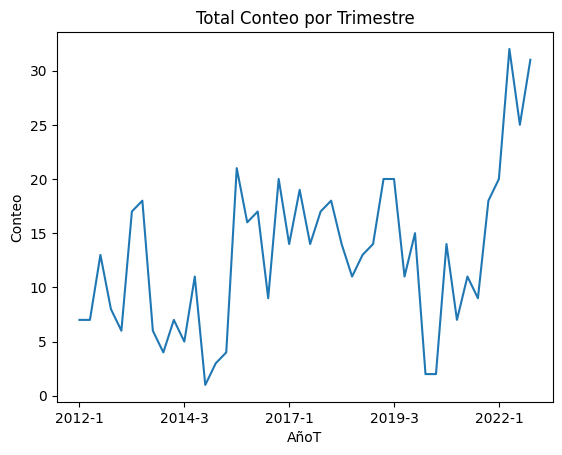

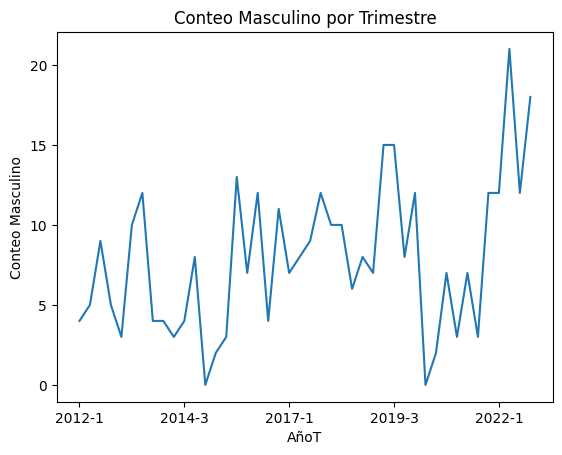

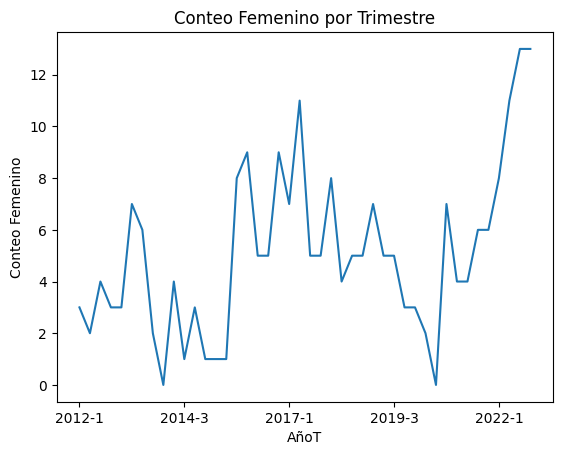

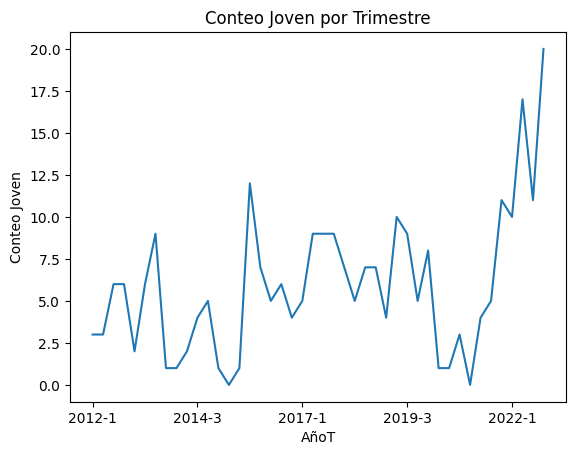

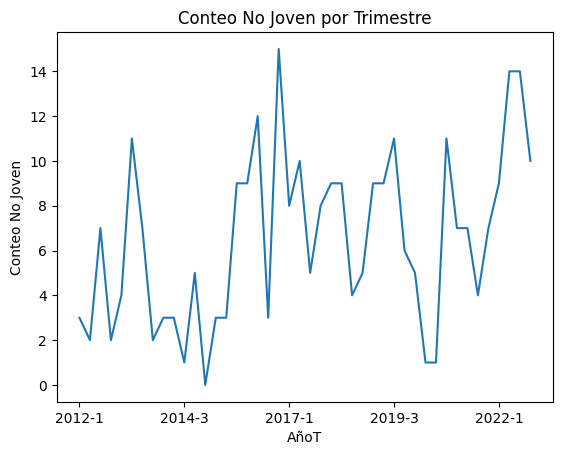

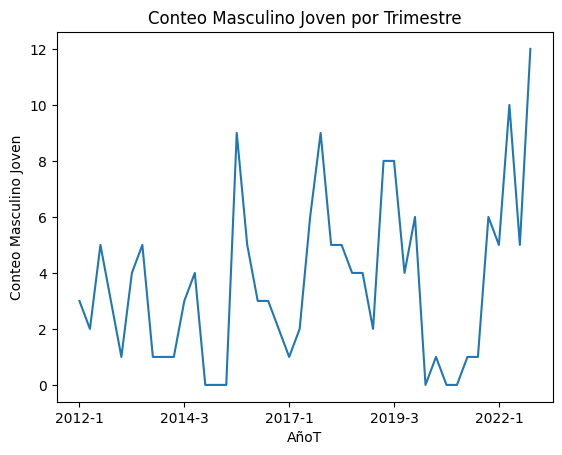

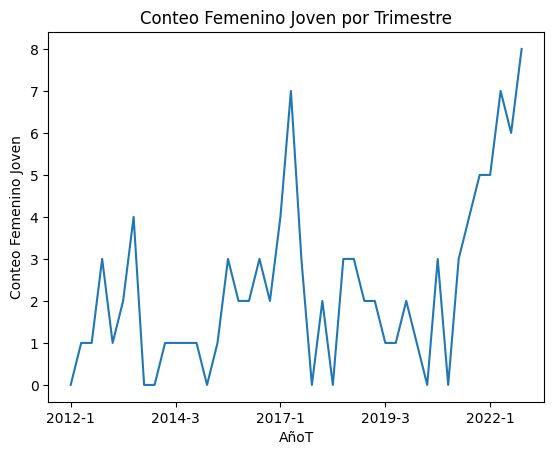

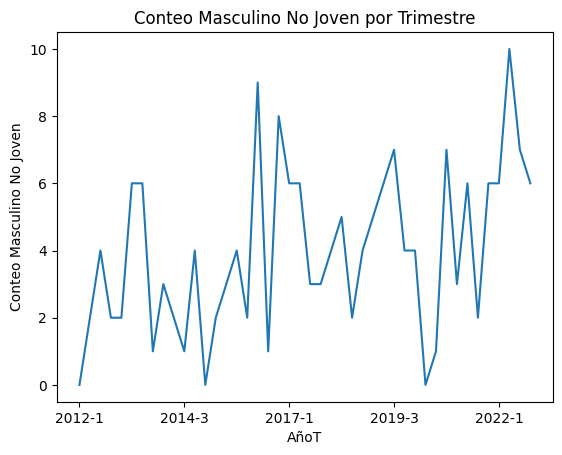

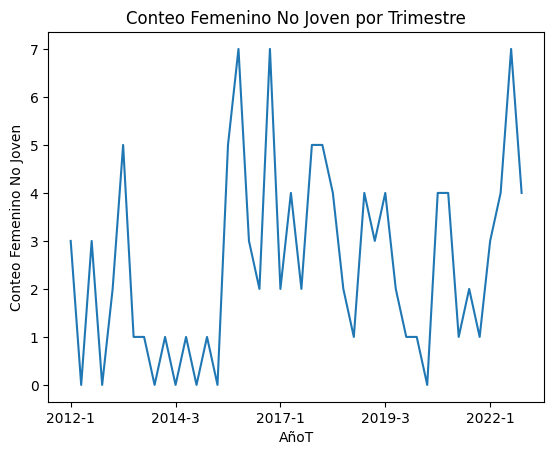

In [11]:
# Plot for Datos_conteo
Datos_conteo.groupby('AñoT')['conteo'].sum().plot(kind='line', title='Total Conteo por Trimestre')
plt.xlabel('AñoT')
plt.ylabel('Conteo')
plt.show()

# Plot for Datos_conteoM
Datos_conteoM.groupby('AñoT')['conteo'].sum().plot(kind='line', title='Conteo Masculino por Trimestre')
plt.xlabel('AñoT')
plt.ylabel('Conteo Masculino')
plt.show()

# Plot for Datos_conteoF
Datos_conteoF.groupby('AñoT')['conteo'].sum().plot(kind='line', title='Conteo Femenino por Trimestre')
plt.xlabel('AñoT')
plt.ylabel('Conteo Femenino')
plt.show()

# Plot for Datos_conteo_joven
Datos_conteo_joven.groupby('AñoT')['conteo'].sum().plot(kind='line', title='Conteo Joven por Trimestre')
plt.xlabel('AñoT')
plt.ylabel('Conteo Joven')
plt.show()

# Plot for Datos_conteo_no_joven
Datos_conteo_no_joven.groupby('AñoT')['conteo'].sum().plot(kind='line', title='Conteo No Joven por Trimestre')
plt.xlabel('AñoT')
plt.ylabel('Conteo No Joven')
plt.show()

# Plot for Datos_conteoM_joven
Datos_conteoM_joven.groupby('AñoT')['conteo'].sum().plot(kind='line', title='Conteo Masculino Joven por Trimestre')
plt.xlabel('AñoT')
plt.ylabel('Conteo Masculino Joven')
plt.show()

# Plot for Datos_conteoF_joven
Datos_conteoF_joven.groupby('AñoT')['conteo'].sum().plot(kind='line', title='Conteo Femenino Joven por Trimestre')
plt.xlabel('AñoT')
plt.ylabel('Conteo Femenino Joven')
plt.show()

# Plot for Datos_conteoM_no_joven
Datos_conteoM_no_joven.groupby('AñoT')['conteo'].sum().plot(kind='line', title='Conteo Masculino No Joven por Trimestre')
plt.xlabel('AñoT')
plt.ylabel('Conteo Masculino No Joven')
plt.show()

# Plot for Datos_conteoF_no_joven
Datos_conteoF_no_joven.groupby('AñoT')['conteo'].sum().plot(kind='line', title='Conteo Femenino No Joven por Trimestre')
plt.xlabel('AñoT')
plt.ylabel('Conteo Femenino No Joven')
plt.show()


In [12]:



def trimestre_to_date(tri) -> pd.Timestamp:
    if isinstance(tri, pd.Timestamp):
        return tri
    año, t = map(int, str(tri).split('-'))
    mes = (t - 1) * 3 + 1
    return pd.Timestamp(year=año, month=mes, day=1)

# --- Función principal ---
def correr_panel_ols2020(df: pd.DataFrame, nombre: str = "DataFrame") -> pd.DataFrame:
    if df.empty:
        return pd.DataFrame()

    df = df.copy()
    df['AñoT_fecha'] = df['AñoT'].apply(trimestre_to_date)
    df_panel = df.set_index(['ESTACION', 'AñoT_fecha']).sort_index()

    try:
        modelo = PanelOLS.from_formula(
            "conteo ~ Treat + Time2020 + TimeT2020",
            data=df_panel,
            drop_absorbed=True
        )
        res = modelo.fit(cov_type="robust")
    except Exception as e:
        print(f"⚠️ Error en {nombre}: {e}")
        return pd.DataFrame()

    # --- Construir tabla organizada ---
    tabla = pd.DataFrame({
        "Coeficiente": res.params,
        "Desv.Estándar": res.std_errors,
        "p-valor": res.pvalues
    })

    # Columna de significancia tipo estrellas
    def estrellas(p):
        if p < 0.01:
            return "***"
        elif p < 0.05:
            return "**"
        elif p < 0.10:
            return "*"
        else:
            return ""

    tabla["Significancia"] = tabla["p-valor"].apply(estrellas)

    # Fila R² (sin estrellas ni p-valor)
    tabla.loc["R²"] = [res.rsquared, None, None, ""]

    # Añadir columna con el nombre del modelo/base
    tabla["Modelo"] = nombre

    return tabla

# --- Bases a analizar ---
bases = {
    "Datos_conteo": Datos_conteo,
    "Datos_conteoM": Datos_conteoM,
    "Datos_conteoF": Datos_conteoF,
    "Datos_conteo_joven": Datos_conteo_joven,
    "Datos_conteo_no_joven": Datos_conteo_no_joven,
    "Datos_conteoM_joven": Datos_conteoM_joven,
    "Datos_conteoF_joven": Datos_conteoF_joven,
    "Datos_conteoM_no_joven": Datos_conteoM_no_joven,
    "Datos_conteoF_no_joven": Datos_conteoF_no_joven
}

# --- Ejecutar todos y concatenar ---
resultados = [correr_panel_ols2020(df, nombre) for nombre, df in bases.items()]
tabla_final = pd.concat(resultados, axis=0)

# --- Mostrar tabla final ---
tabla_final



C:\Users\Felipe Bañol\AppData\Local\Temp\ipykernel_3660\331146607.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tabla.loc["R²"] = [res.rsquared, None, None, ""]
C:\Users\Felipe Bañol\AppData\Local\Temp\ipykernel_3660\331146607.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tabla.loc["R²"] = [res.rsquared, None, None, ""]
C:\Users\Felipe Bañol\AppData\Local\Temp\ipykernel_3660\331146607.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is depr

,Coeficiente,Desv.Estándar,p-valor,Significancia,Modelo
Treat,0.757576,0.085900,0.000000e+00,***,Datos_conteo
Time2020,0.509881,0.056970,0.000000e+00,***,Datos_conteo
TimeT2020,-0.312912,0.228044,1.702755e-01,,Datos_conteo
R²,0.170538,NaN,NaN,,Datos_conteo
Treat,0.462121,0.061066,7.616130e-14,***,Datos_conteoM
Time2020,0.292490,0.042321,7.831291e-12,***,Datos_conteoM
TimeT2020,-0.231884,0.139606,9.698098e-02,*,Datos_conteoM
R²,0.118726,NaN,NaN,,Datos_conteoM
Treat,0.295455,0.055470,1.198152e-07,***,Datos_conteoF
Time2020,0.217391,0.032884,5.767831e-11,***,Datos_conteoF


In [13]:

def trimestre_to_date(tri) -> pd.Timestamp:
    if isinstance(tri, pd.Timestamp):
        return tri
    año, t = map(int, str(tri).split('-'))
    mes = (t - 1) * 3 + 1
    return pd.Timestamp(year=año, month=mes, day=1)

# --- Función principal ---
def correr_panel_ols2022(df: pd.DataFrame, nombre: str = "DataFrame") -> pd.DataFrame:
    if df.empty:
        return pd.DataFrame()

    df = df.copy()
    df['AñoT_fecha'] = df['AñoT'].apply(trimestre_to_date)
    df_panel = df.set_index(['ESTACION', 'AñoT_fecha']).sort_index()

    try:
        modelo = PanelOLS.from_formula(
            "conteo ~ Treat + Time2022 + TimeT2022",
            data=df_panel,
            drop_absorbed=True
        )
        res = modelo.fit(cov_type="robust")
    except Exception as e:
        print(f"⚠️ Error en {nombre}: {e}")
        return pd.DataFrame()

    # --- Construir tabla organizada ---
    tabla = pd.DataFrame({
        "Coeficiente": res.params,
        "Desv.Estándar": res.std_errors,
        "p-valor": res.pvalues
    })

    # Columna de significancia tipo estrellas
    def estrellas(p):
        if p < 0.01:
            return "***"
        elif p < 0.05:
            return "**"
        elif p < 0.10:
            return "*"
        else:
            return ""

    tabla["Significancia"] = tabla["p-valor"].apply(estrellas)

    # Fila R² (sin estrellas ni p-valor)
    tabla.loc["R²"] = [res.rsquared, None, None, ""]

    # Añadir columna con el nombre del modelo/base
    tabla["Modelo"] = nombre

    return tabla

# --- Bases a analizar ---
bases = {
    "Datos_conteo": Datos_conteo,
    "Datos_conteoM": Datos_conteoM,
    "Datos_conteoF": Datos_conteoF,
    "Datos_conteo_joven": Datos_conteo_joven,
    "Datos_conteo_no_joven": Datos_conteo_no_joven,
    "Datos_conteoM_joven": Datos_conteoM_joven,
    "Datos_conteoF_joven": Datos_conteoF_joven,
    "Datos_conteoM_no_joven": Datos_conteoM_no_joven,
    "Datos_conteoF_no_joven": Datos_conteoF_no_joven
}

# --- Ejecutar todos y concatenar ---
resultados = [correr_panel_ols2022(df, nombre) for nombre, df in bases.items()]
tabla_final = pd.concat(resultados, axis=0)

# --- Mostrar tabla final ---



C:\Users\Felipe Bañol\AppData\Local\Temp\ipykernel_3660\270947147.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tabla.loc["R²"] = [res.rsquared, None, None, ""]
C:\Users\Felipe Bañol\AppData\Local\Temp\ipykernel_3660\270947147.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tabla.loc["R²"] = [res.rsquared, None, None, ""]
C:\Users\Felipe Bañol\AppData\Local\Temp\ipykernel_3660\270947147.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is depr

In [14]:

from scipy.stats import norm
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.special import factorial

# -------------------------------
# Funciones auxiliares Poisson MLE
# -------------------------------

def mu(beta, X):
    return np.exp(np.dot(X, beta))

def neg_log_likelihood(beta, X, y):
    mu_val = mu(beta, X)
    return -np.sum(y*np.log(mu_val) - mu_val - np.log(factorial(y)))

def estimar_poisson(df: pd.DataFrame, nombre: str):
    df = df[['conteo','Treat','Time2022','TimeT2022']].dropna()

    y = df['conteo'].astype(float).to_numpy()
    X = df[['Treat','Time2022','TimeT2022']].astype(float).to_numpy()
    X = np.column_stack([np.ones(len(y)), X])  # agregar constante

    beta_init = np.zeros(X.shape[1])
    result = minimize(neg_log_likelihood, beta_init, args=(X, y), method='BFGS')

    if not result.success:
        print(f"⚠️ No convergió el modelo en {nombre}: {result.message}")
        return None

    beta_hat = result.x
    hess_inv = result.hess_inv
    std_err = np.sqrt(np.diag(hess_inv))
    z_values = beta_hat / std_err
    p_values = 2 * (1 - norm.cdf(np.abs(z_values)))

    def estrellas(p):
        if p < 0.01: return "***"
        elif p < 0.05: return "**"
        elif p < 0.10: return "*"
        else: return ""

    signif = [estrellas(p) for p in p_values]

    # -------------------------------
    # Test de sobredispersión Cameron-Trivedi (solo una vez por modelo)
    # -------------------------------
    mu_hat = mu(beta_hat, X)
    residuos_pearson = (y - mu_hat) / np.sqrt(mu_hat)
    alpha_hat = (np.sum(residuos_pearson**2) - len(y)) / np.sum(mu_hat**2)
    z_alpha = alpha_hat / np.sqrt(2/len(y))
    p_alpha = 2 * (1 - norm.cdf(np.abs(z_alpha)))

    nombres_vars = ["Constante","Treat","Time2022","TimeT2022"]
    tabla_coef = pd.DataFrame({
        "Coeficiente": beta_hat,
        "Desv.Estándar": std_err,
        "z": z_values,
        "p-valor": p_values,
        "Significancia": signif
    }, index=nombres_vars)

    # Fila Travis Scott (sobredispersión)
    tabla_travis = pd.DataFrame({
        "Coeficiente": [np.nan],
        "Desv.Estándar": [np.nan],
        "z": [np.nan],
        "p-valor": [np.nan],
        "Significancia": [f"Alpha={alpha_hat:.4f}, p={p_alpha:.4f}"]
    }, index=[f"Travis_Scott_{nombre}"])

    # Concatenar coeficientes + Travis Scott
    tabla_final_modelo = pd.concat([tabla_coef, tabla_travis])
    tabla_final_modelo["Modelo"] = nombre

    return tabla_final_modelo

# -------------------------------
# Aplicar a todas las bases
# -------------------------------

bases = {
    "Datos_conteo": Datos_conteo,
    "Datos_conteoM": Datos_conteoM,
    "Datos_conteoF": Datos_conteoF,
    "Datos_conteo_joven": Datos_conteo_joven,
    "Datos_conteo_no_joven": Datos_conteo_no_joven,
    "Datos_conteoM_joven": Datos_conteoM_joven,
    "Datos_conteoF_joven": Datos_conteoF_joven,
    "Datos_conteoM_no_joven": Datos_conteoM_no_joven,
    "Datos_conteoF_no_joven": Datos_conteoF_no_joven
}

resultados = []
for nombre, df in bases.items():
    tabla = estimar_poisson(df, nombre)
    if tabla is not None:
        resultados.append(tabla)

tabla_final = pd.concat(resultados)
tabla_final



⚠️ No convergió el modelo en Datos_conteo: Desired error not necessarily achieved due to precision loss.


,Coeficiente,Desv.Estándar,z,p-valor,Significancia,Modelo
Constante,-1.472516,0.067398,-21.848101,0.000000e+00,***,Datos_conteoM
Treat,0.687801,0.130713,5.261906,1.425694e-07,***,Datos_conteoM
Time2022,0.901971,0.141708,6.364978,1.953180e-10,***,Datos_conteoM
TimeT2022,-0.491950,0.348718,-1.410741,1.583210e-01,,Datos_conteoM
Travis_Scott_Datos_conteoM,NaN,NaN,NaN,NaN,"Alpha=1.1888, p=0.0000",Datos_conteoM
Constante,-1.941572,0.085567,-22.690768,0.000000e+00,***,Datos_conteoF
Treat,0.716545,0.153757,4.660247,3.158296e-06,***,Datos_conteoF
Time2022,0.946144,0.179537,5.269917,1.364856e-07,***,Datos_conteoF
TimeT2022,-0.095810,0.382650,-0.250386,8.022886e-01,,Datos_conteoF
Travis_Scott_Datos_conteoF,NaN,NaN,NaN,NaN,"Alpha=0.9376, p=0.0000",Datos_conteoF


In [15]:
# -------------------------------
# Funciones auxiliares Poisson MLE
# -------------------------------

# Función de tasa Poisson (log-lineal)
def mu(beta, X):
    return np.exp(np.dot(X, beta))

# Log-verosimilitud negativa
def neg_log_likelihood(beta, X, y):
    mu_val = mu(beta, X)
    return -np.sum(y*np.log(mu_val) - mu_val - np.log(factorial(y)))

# Estimación Poisson por MLE para una base
def estimar_poisson(df: pd.DataFrame, nombre: str):
    # Quitar filas con NA
    df = df[['conteo','Treat','Time2020','TimeT2020']].dropna()

    # Matriz de diseño: columna de 1's + variables explicativas
    y = df['conteo'].astype(float).to_numpy()
    X = df[['Treat','Time2020','TimeT2020']].astype(float).to_numpy()
    X = np.column_stack([np.ones(len(y)), X])  # agregar constante

    # Estimación por MLE
    beta_init = np.zeros(X.shape[1])
    result = minimize(neg_log_likelihood, beta_init, args=(X, y), method='BFGS')

    if not result.success:
        print(f"⚠️ No convergió el modelo en {nombre}: {result.message}")
        return None

    # Extraer resultados
    beta_hat = result.x
    # Error estándar = raíz de la diagonal de la inversa del Hessiano
    hess_inv = result.hess_inv
    std_err = np.sqrt(np.diag(hess_inv))
    z_values = beta_hat / std_err
    p_values = 2 * (1 - norm.cdf(np.abs(z_values)))  # ✅ p-valores correctos

    # Estrellas de significancia
    def estrellas(p):
        if p < 0.01: return "***"
        elif p < 0.05: return "**"
        elif p < 0.10: return "*"
        else: return ""

    signif = [estrellas(p) for p in p_values]

    # Crear tabla
    nombres_vars = ["Constante","Treat","Time2020","TimeT2020"]
    tabla = pd.DataFrame({
        "Coeficiente": beta_hat,
        "Desv.Estándar": std_err,
        "z": z_values,
        "p-valor": p_values,
        "Significancia": signif,
        "Modelo": nombre
    }, index=nombres_vars)

    return tabla

# -------------------------------
# Aplicar a todas las bases
# -------------------------------

bases = {
    "Datos_conteo": Datos_conteo,
    "Datos_conteoM": Datos_conteoM,
    "Datos_conteoF": Datos_conteoF,
    "Datos_conteo_joven": Datos_conteo_joven,
    "Datos_conteo_no_joven": Datos_conteo_no_joven,
    "Datos_conteoM_joven": Datos_conteoM_joven,
    "Datos_conteoF_joven": Datos_conteoF_joven,
    "Datos_conteoM_no_joven": Datos_conteoM_no_joven,
    "Datos_conteoF_no_joven": Datos_conteoF_no_joven
}

resultados = []
for nombre, df in bases.items():
    tabla = estimar_poisson(df, nombre)
    if tabla is not None:
        resultados.append(tabla)

# Unir todo en una tabla final
tabla_final = pd.concat(resultados)
tabla_final

⚠️ No convergió el modelo en Datos_conteo: Desired error not necessarily achieved due to precision loss.


,Coeficiente,Desv.Estándar,z,p-valor,Significancia,Modelo
Constante,-1.390255,0.072417,-19.198012,0.000000,***,Datos_conteoM
Treat,0.618327,0.145090,4.261662,0.000020,***,Datos_conteoM
Time2020,0.160930,0.136340,1.180360,0.237857,,Datos_conteoM
TimeT2020,-0.037697,0.270101,-0.139567,0.889002,,Datos_conteoM
Constante,-1.922472,0.117163,-16.408473,0.000000,***,Datos_conteoF
Treat,0.703231,0.444954,1.580459,0.114002,,Datos_conteoF
Time2020,0.396415,0.188115,2.107299,0.035092,**,Datos_conteoF
TimeT2020,-0.016925,0.493423,-0.034302,0.972636,,Datos_conteoF
Constante,-1.764467,0.084549,-20.869246,0.000000,***,Datos_conteo_joven
Treat,0.752866,0.170421,4.417698,0.000010,***,Datos_conteo_joven


In [16]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize, approx_fprime
from scipy.special import expit, gammaln
from scipy.stats import norm
import numdifftools as nd

# ------------------------------------
# Funciones comunes
# ------------------------------------
def estrellas(p): 
    if p < 0.01: return "***"
    if p < 0.05: return "**"
    if p < 0.10: return "*"
    return ""

def log_pmf_pois(y, mu):
    return y*np.log(mu) - mu - gammaln(y+1)

def log_pmf_nb(y, mu, alpha):
    r = 1/alpha
    return gammaln(y+r) - gammaln(r) - gammaln(y+1) + r*np.log(r/(r+mu)) + y*np.log(mu/(r+mu))

# ------------------------------------
# ZIP MLE
# ------------------------------------
def neg_loglik_zip(params, X, y, k_beta, k_gamma):
    beta = params[:k_beta]
    gamma = params[k_beta:k_beta+k_gamma]

    mu = np.exp(X.dot(beta))
    pi = expit(X.dot(gamma))
    eps = 1e-12
    pi = np.clip(pi, eps, 1-eps)

    log_pmf = log_pmf_pois(y, mu)

    ll = np.empty_like(y, dtype=float)
    is_zero = (y==0)
    if np.any(is_zero):
        a = np.log(pi[is_zero])
        b = np.log(1-pi[is_zero]) + log_pmf[is_zero]
        m = np.maximum(a,b)
        ll[is_zero] = m + np.log(np.exp(a-m)+np.exp(b-m))
    if np.any(~is_zero):
        ll[~is_zero] = np.log(1-pi[~is_zero]) + log_pmf[~is_zero]
    return -np.sum(ll)

# ------------------------------------
# ZINB MLE
# ------------------------------------
def neg_loglik_zinb(params, X, y, k_beta, k_gamma):
    beta = params[:k_beta]
    gamma = params[k_beta:k_beta+k_gamma]
    alpha = np.exp(params[-1])

    mu = np.exp(X.dot(beta))
    pi = expit(X.dot(gamma))
    eps = 1e-12
    pi = np.clip(pi, eps, 1-eps)

    log_pmf = log_pmf_nb(y, mu, alpha)

    ll = np.empty_like(y, dtype=float)
    is_zero = (y==0)
    if np.any(is_zero):
        a = np.log(pi[is_zero])
        b = np.log(1-pi[is_zero]) + log_pmf[is_zero]
        m = np.maximum(a,b)
        ll[is_zero] = m + np.log(np.exp(a-m)+np.exp(b-m))
    if np.any(~is_zero):
        ll[~is_zero] = np.log(1-pi[~is_zero]) + log_pmf[~is_zero]
    return -np.sum(ll)

# ------------------------------------
# Estimador combinado
# ------------------------------------
def estimar_zip_zinb(df, nombre, formula_vars=["Treat","Time2022","TimeT2022"]):
    df2 = df[["conteo"]+formula_vars].dropna()
    if df2.shape[0] == 0:
        print(f"⚠️ {nombre}: sin datos tras dropna.")
        return None

    y = df2["conteo"].astype(int).to_numpy()
    X = df2[formula_vars].astype(float).to_numpy()
    X = np.column_stack([np.ones(len(y)), X])
    k = X.shape[1]

    sobredisp = np.var(y) > np.mean(y)*1.2
    modelo = "ZINB" if sobredisp else "ZIP"

    if modelo == "ZIP":
        mean_y = np.mean(y) if np.mean(y)>0 else 0.1
        beta_init = np.zeros(k); beta_init[0] = np.log(mean_y+1e-3)
        p0 = np.mean(y==0)
        gamma_init = np.zeros(k); gamma_init[0] = np.log((p0+1e-3)/(1-p0+1e-3))
        params_init = np.concatenate([beta_init, gamma_init])
        obj = lambda p: neg_loglik_zip(p, X, y, k, k)
        n_params = k*2
    else:
        mean_y = np.mean(y) if np.mean(y)>0 else 0.1
        beta_init = np.zeros(k); beta_init[0] = np.log(mean_y+1e-3)
        p0 = np.mean(y==0)
        gamma_init = np.zeros(k); gamma_init[0] = np.log((p0+1e-3)/(1-p0+1e-3))
        alpha_init = np.log(0.5)
        params_init = np.concatenate([beta_init, gamma_init, [alpha_init]])
        obj = lambda p: neg_loglik_zinb(p, X, y, k, k)
        n_params = k*2+1

    result = minimize(obj, params_init, method="L-BFGS-B",
                      options={"maxiter":1000,"ftol":1e-8})

    if not result.success:
        print(f"⚠️ No convergió {modelo} en {nombre}: {result.message}")
        return None

    params_hat = result.x

    # ---- Hessiana numérica para errores estándar ----
    H = nd.Hessian(obj)(params_hat)
    try:
        cov = np.linalg.inv(H)
        se = np.sqrt(np.diag(cov))
    except np.linalg.LinAlgError:
        se = np.full(n_params, np.nan)

    # ---- Armar tabla ----
    if modelo == "ZIP":
        beta_hat = params_hat[:k]
        gamma_hat = params_hat[k:k*2]
        se_beta, se_gamma = se[:k], se[k:k*2]
        z_beta, z_gamma = beta_hat/se_beta, gamma_hat/se_gamma
        p_beta = 2*(1-norm.cdf(np.abs(z_beta)))
        p_gamma = 2*(1-norm.cdf(np.abs(z_gamma)))
        idx = ["Const_count"]+formula_vars+["Const_infl"]+formula_vars
        coef = np.concatenate([beta_hat,gamma_hat])
        desv = np.concatenate([se_beta,se_gamma])
        zvals = np.concatenate([z_beta,z_gamma])
        pvals = np.concatenate([p_beta,p_gamma])
    else:
        beta_hat = params_hat[:k]
        gamma_hat = params_hat[k:k*2]
        alpha_hat = np.exp(params_hat[-1])
        se_beta, se_gamma, se_alpha = se[:k], se[k:k*2], se[-1]
        z_beta, z_gamma = beta_hat/se_beta, gamma_hat/se_gamma
        p_beta = 2*(1-norm.cdf(np.abs(z_beta)))
        p_gamma = 2*(1-norm.cdf(np.abs(z_gamma)))
        idx = ["Const_count"]+formula_vars+["Const_infl"]+formula_vars+["alpha"]
        coef = np.concatenate([beta_hat,gamma_hat,[alpha_hat]])
        desv = np.concatenate([se_beta,se_gamma,[se_alpha]])
        zvals = np.concatenate([z_beta,z_gamma,[np.nan]])
        pvals = np.concatenate([p_beta,p_gamma,[np.nan]])

    signif = [estrellas(p) if not np.isnan(p) else "" for p in pvals]

    tabla = pd.DataFrame({
        "Coeficiente": coef,
        "Desv.Estándar": desv,
        "z": zvals,
        "p-valor": pvals,
        "Significancia": signif,
        "Modelo": f"{modelo} - {nombre}"
    }, index=idx)

    return tabla

# ------------------------------------
# Aplicar a todas las bases
# ------------------------------------
bases = {
    "Datos_conteo": Datos_conteo,
    "Datos_conteoM": Datos_conteoM,
    "Datos_conteoF": Datos_conteoF,
    "Datos_conteo_joven": Datos_conteo_joven,
    "Datos_conteo_no_joven": Datos_conteo_no_joven,
    "Datos_conteoM_joven": Datos_conteoM_joven,
    "Datos_conteoF_joven": Datos_conteoF_joven,
    "Datos_conteoM_no_joven": Datos_conteoM_no_joven,
    "Datos_conteoF_no_joven": Datos_conteoF_no_joven
}

resultados = []
for nombre, df in bases.items():
    tabla = estimar_zip_zinb(df, nombre)
    if tabla is not None:
        resultados.append(tabla)

if resultados:
    tabla_final = pd.concat(resultados)
    display(tabla_final)
else:
    print("No se obtuvieron estimaciones.")


C:\Users\Felipe Bañol\AppData\Local\Temp\ipykernel_3660\314661242.py:123: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(cov))
C:\Users\Felipe Bañol\AppData\Local\Temp\ipykernel_3660\314661242.py:123: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(cov))


,Coeficiente,Desv.Estándar,z,p-valor,Significancia,Modelo
Const_count,-0.986716,0.058043,-16.999698,0.000000e+00,***,ZINB - Datos_conteo
Treat,0.699338,0.119592,5.847697,4.984254e-09,***,ZINB - Datos_conteo
Time2022,1.018711,0.207416,4.911428,9.041534e-07,***,ZINB - Datos_conteo
TimeT2022,-0.309167,0.419722,-0.736599,4.613664e-01,,ZINB - Datos_conteo
Const_infl,-12.678223,222.870245,-0.056886,9.546359e-01,,ZINB - Datos_conteo
...,...,...,...,...,...,...
TimeT2022,0.069130,1.123537,0.061529,9.509377e-01,,ZIP - Datos_conteoF_no_joven
Const_infl,-15.487417,1678.774526,-0.009225,9.926393e-01,,ZIP - Datos_conteoF_no_joven
Treat,-0.276283,NaN,NaN,NaN,,ZIP - Datos_conteoF_no_joven
Time2022,16.099612,1678.774713,0.009590,9.923483e-01,,ZIP - Datos_conteoF_no_joven


In [17]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize, approx_fprime
from scipy.special import expit, gammaln
from scipy.stats import norm
import numdifftools as nd

# ------------------------------------
# Funciones comunes
# ------------------------------------
def estrellas(p): 
    if p < 0.01: return "***"
    if p < 0.05: return "**"
    if p < 0.10: return "*"
    return ""

def log_pmf_pois(y, mu):
    return y*np.log(mu) - mu - gammaln(y+1)

def log_pmf_nb(y, mu, alpha):
    r = 1/alpha
    return gammaln(y+r) - gammaln(r) - gammaln(y+1) + r*np.log(r/(r+mu)) + y*np.log(mu/(r+mu))

# ------------------------------------
# ZIP MLE
# ------------------------------------
def neg_loglik_zip(params, X, y, k_beta, k_gamma):
    beta = params[:k_beta]
    gamma = params[k_beta:k_beta+k_gamma]

    mu = np.exp(X.dot(beta))
    pi = expit(X.dot(gamma))
    eps = 1e-12
    pi = np.clip(pi, eps, 1-eps)

    log_pmf = log_pmf_pois(y, mu)

    ll = np.empty_like(y, dtype=float)
    is_zero = (y==0)
    if np.any(is_zero):
        a = np.log(pi[is_zero])
        b = np.log(1-pi[is_zero]) + log_pmf[is_zero]
        m = np.maximum(a,b)
        ll[is_zero] = m + np.log(np.exp(a-m)+np.exp(b-m))
    if np.any(~is_zero):
        ll[~is_zero] = np.log(1-pi[~is_zero]) + log_pmf[~is_zero]
    return -np.sum(ll)

# ------------------------------------
# ZINB MLE
# ------------------------------------
def neg_loglik_zinb(params, X, y, k_beta, k_gamma):
    beta = params[:k_beta]
    gamma = params[k_beta:k_beta+k_gamma]
    alpha = np.exp(params[-1])

    mu = np.exp(X.dot(beta))
    pi = expit(X.dot(gamma))
    eps = 1e-12
    pi = np.clip(pi, eps, 1-eps)

    log_pmf = log_pmf_nb(y, mu, alpha)

    ll = np.empty_like(y, dtype=float)
    is_zero = (y==0)
    if np.any(is_zero):
        a = np.log(pi[is_zero])
        b = np.log(1-pi[is_zero]) + log_pmf[is_zero]
        m = np.maximum(a,b)
        ll[is_zero] = m + np.log(np.exp(a-m)+np.exp(b-m))
    if np.any(~is_zero):
        ll[~is_zero] = np.log(1-pi[~is_zero]) + log_pmf[~is_zero]
    return -np.sum(ll)

# ------------------------------------
# Estimador combinado
# ------------------------------------
def estimar_zip_zinb(df, nombre, formula_vars=["Treat","Time2020","TimeT2020"]):
    df2 = df[["conteo"]+formula_vars].dropna()
    if df2.shape[0] == 0:
        print(f"⚠️ {nombre}: sin datos tras dropna.")
        return None

    y = df2["conteo"].astype(int).to_numpy()
    X = df2[formula_vars].astype(float).to_numpy()
    X = np.column_stack([np.ones(len(y)), X])
    k = X.shape[1]
#Cambiar esto por prueba de overdispersion
    sobredisp = np.var(y) > np.mean(y)*1.2
    modelo = "ZINB" if sobredisp else "ZIP"

    if modelo == "ZIP":
        mean_y = np.mean(y) if np.mean(y)>0 else 0.1
        beta_init = np.zeros(k); beta_init[0] = np.log(mean_y+1e-3)
        p0 = np.mean(y==0)
        gamma_init = np.zeros(k); gamma_init[0] = np.log((p0+1e-3)/(1-p0+1e-3))
        params_init = np.concatenate([beta_init, gamma_init])
        obj = lambda p: neg_loglik_zip(p, X, y, k, k)
        n_params = k*2
    else:
        mean_y = np.mean(y) if np.mean(y)>0 else 0.1
        beta_init = np.zeros(k); beta_init[0] = np.log(mean_y+1e-3)
        p0 = np.mean(y==0)
        gamma_init = np.zeros(k); gamma_init[0] = np.log((p0+1e-3)/(1-p0+1e-3))
        alpha_init = np.log(0.5)
        params_init = np.concatenate([beta_init, gamma_init, [alpha_init]])
        obj = lambda p: neg_loglik_zinb(p, X, y, k, k)
        n_params = k*2+1

    result = minimize(obj, params_init, method="L-BFGS-B",
                      options={"maxiter":1000,"ftol":1e-8})

    if not result.success:
        print(f"⚠️ No convergió {modelo} en {nombre}: {result.message}")
        return None

    params_hat = result.x

    # ---- Hessiana numérica para errores estándar ----
    H = nd.Hessian(obj)(params_hat)
    try:
        cov = np.linalg.inv(H)
        se = np.sqrt(np.diag(cov))
    except np.linalg.LinAlgError:
        se = np.full(n_params, np.nan)

    # ---- Armar tabla ----
    if modelo == "ZIP":
        beta_hat = params_hat[:k]
        gamma_hat = params_hat[k:k*2]
        se_beta, se_gamma = se[:k], se[k:k*2]
        z_beta, z_gamma = beta_hat/se_beta, gamma_hat/se_gamma
        p_beta = 2*(1-norm.cdf(np.abs(z_beta)))
        p_gamma = 2*(1-norm.cdf(np.abs(z_gamma)))
        idx = ["Const_count"]+formula_vars+["Const_infl"]+formula_vars
        coef = np.concatenate([beta_hat,gamma_hat])
        desv = np.concatenate([se_beta,se_gamma])
        zvals = np.concatenate([z_beta,z_gamma])
        pvals = np.concatenate([p_beta,p_gamma])
    else:
        beta_hat = params_hat[:k]
        gamma_hat = params_hat[k:k*2]
        alpha_hat = np.exp(params_hat[-1])
        se_beta, se_gamma, se_alpha = se[:k], se[k:k*2], se[-1]
        z_beta, z_gamma = beta_hat/se_beta, gamma_hat/se_gamma
        p_beta = 2*(1-norm.cdf(np.abs(z_beta)))
        p_gamma = 2*(1-norm.cdf(np.abs(z_gamma)))
        idx = ["Const_count"]+formula_vars+["Const_infl"]+formula_vars+["alpha"]
        coef = np.concatenate([beta_hat,gamma_hat,[alpha_hat]])
        desv = np.concatenate([se_beta,se_gamma,[se_alpha]])
        zvals = np.concatenate([z_beta,z_gamma,[np.nan]])
        pvals = np.concatenate([p_beta,p_gamma,[np.nan]])

    signif = [estrellas(p) if not np.isnan(p) else "" for p in pvals]

    tabla = pd.DataFrame({
        "Coeficiente": coef,
        "Desv.Estándar": desv,
        "z": zvals,
        "p-valor": pvals,
        "Significancia": signif,
        "Modelo": f"{modelo} - {nombre}"
    }, index=idx)

    return tabla

# ------------------------------------
# Aplicar a todas las bases
# ------------------------------------
bases = {
    "Datos_conteo": Datos_conteo,
    "Datos_conteoM": Datos_conteoM,
    "Datos_conteoF": Datos_conteoF,
    "Datos_conteo_joven": Datos_conteo_joven,
    "Datos_conteo_no_joven": Datos_conteo_no_joven,
    "Datos_conteoM_joven": Datos_conteoM_joven,
    "Datos_conteoF_joven": Datos_conteoF_joven,
    "Datos_conteoM_no_joven": Datos_conteoM_no_joven,
    "Datos_conteoF_no_joven": Datos_conteoF_no_joven
}

resultados = []
for nombre, df in bases.items():
    tabla = estimar_zip_zinb(df, nombre)
    if tabla is not None:
        resultados.append(tabla)

if resultados:
    tabla_final = pd.concat(resultados)
    display(tabla_final)
else:
    print("No se obtuvieron estimaciones.")


C:\Users\Felipe Bañol\AppData\Local\Temp\ipykernel_3660\1877492994.py:123: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(cov))
C:\Users\Felipe Bañol\AppData\Local\Temp\ipykernel_3660\1877492994.py:123: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(cov))
C:\Users\Felipe Bañol\AppData\Local\Temp\ipykernel_3660\1877492994.py:123: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(cov))


,Coeficiente,Desv.Estándar,z,p-valor,Significancia,Modelo
Const_count,-0.928272,0.062804,-14.780470,0.000000e+00,***,ZINB - Datos_conteo
Treat,0.650746,0.132069,4.927331,8.336047e-07,***,ZINB - Datos_conteo
Time2020,0.431207,0.199573,2.160646,3.072266e-02,**,ZINB - Datos_conteo
TimeT2020,0.076514,0.344211,0.222288,8.240894e-01,,ZINB - Datos_conteo
Const_infl,-11.483193,151.661217,-0.075716,9.396450e-01,,ZINB - Datos_conteo
...,...,...,...,...,...,...
TimeT2020,-0.020297,1.149795,-0.017653,9.859160e-01,,ZIP - Datos_conteoF_no_joven
Const_infl,-10.163815,131.309135,-0.077404,9.383024e-01,,ZIP - Datos_conteoF_no_joven
Treat,0.297537,NaN,NaN,NaN,,ZIP - Datos_conteoF_no_joven
Time2020,10.527860,131.312278,0.080174,9.360987e-01,,ZIP - Datos_conteoF_no_joven
